In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, f1_score, accuracy_score,
                           precision_score, recall_score, confusion_matrix,
                           roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA LOADING

In [27]:
data_all = pd.read_csv('processed_data_with_all_features.csv')
train_data = pd.read_csv('tvt_70_15_15_train_bimodal_balanced.csv')
test_data = pd.read_csv('tvt_70_15_15_test_bimodal_balanced.csv')
val_data = pd.read_csv('tvt_70_15_15_validate_bimodal_balanced.csv')

print(f"Train: {len(train_data)}, Test: {len(test_data)}, Val: {len(val_data)}")

Train: 1400, Test: 300, Val: 300


DATA PREPARATION

In [28]:
train_test1 = train_data.merge(data_all, left_on='Song', right_on='Audio_Song', how='left', indicator=True)
train_test2 = train_data.merge(data_all, left_on='Song', right_on='Lyric_Song', how='left', indicator=True)

if (train_test1['_merge'] == 'both').sum() >= (train_test2['_merge'] == 'both').sum():
    song_col = 'Audio_Song'
else:
    song_col = 'Lyric_Song'

train_full = train_data.merge(data_all, left_on='Song', right_on=song_col, how='left')
test_full = test_data.merge(data_all, left_on='Song', right_on=song_col, how='left')
val_full = val_data.merge(data_all, left_on='Song', right_on=song_col, how='left')

audio_features = [
    'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std',
    'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std',
    'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std',
    'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std',
    'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
    'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std',
    'mfcc_12_mean', 'mfcc_12_std', 'chroma_mean', 'chroma_std',
    'spectral_contrast_mean', 'spectral_contrast_std',
    'spectral_bandwidth_mean', 'spectral_bandwidth_std',
    'spectral_rolloff_mean', 'spectral_rolloff_std',
    'tempo', 'zcr_mean', 'zcr_std', 'rms_mean', 'rms_std',
    'harmonic_mean', 'harmonic_std', 'percussive_mean', 'percussive_std'
]

available_audio_features = [f for f in audio_features if f in train_full.columns]
print(f"Audio features: {len(available_audio_features)}")

scaler = StandardScaler()
train_audio = scaler.fit_transform(train_full[available_audio_features].fillna(0))
test_audio = scaler.transform(test_full[available_audio_features].fillna(0))
val_audio = scaler.transform(val_full[available_audio_features].fillna(0))

lyrics_col = None
for col in ['lyrics_processed', 'lyrics_tokens', 'Lyrics', 'lyrics']:
    if col in train_full.columns:
        lyrics_col = col
        break
if not lyrics_col:
    lyrics_col = [c for c in train_full.columns if 'lyric' in c.lower()][0]

train_lyrics = train_full[lyrics_col].fillna('').astype(str).tolist()
test_lyrics = test_full[lyrics_col].fillna('').astype(str).tolist()
val_lyrics = val_full[lyrics_col].fillna('').astype(str).tolist()

quadrant_map = {'Q1': 0, 'Q2': 1, 'Q3': 2, 'Q4': 3}
train_labels = train_data['Quadrant'].map(quadrant_map).values
test_labels = test_data['Quadrant'].map(quadrant_map).values
val_labels = val_data['Quadrant'].map(quadrant_map).values

class_counts = np.bincount(train_labels)
class_weights = torch.FloatTensor(1.0 / class_counts).to(device)
class_weights = class_weights / class_weights.sum() * len(class_counts)

Audio features: 37


TOKENIZATION

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_lyrics(lyrics_list, max_length=128):
    encodings = tokenizer(
        lyrics_list,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

train_input_ids, train_attention_mask = tokenize_lyrics(train_lyrics)
test_input_ids, test_attention_mask = tokenize_lyrics(test_lyrics)
val_input_ids, val_attention_mask = tokenize_lyrics(val_lyrics)

 DATASET

In [30]:
class MusicEmotionDataset(Dataset):
    def __init__(self, input_ids, attention_mask, audio_features, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.audio_features = torch.FloatTensor(audio_features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'audio': self.audio_features[idx],
            'label': self.labels[idx]
        }

train_dataset = MusicEmotionDataset(train_input_ids, train_attention_mask, train_audio, train_labels)
test_dataset = MusicEmotionDataset(test_input_ids, test_attention_mask, test_audio, test_labels)
val_dataset = MusicEmotionDataset(val_input_ids, val_attention_mask, val_audio, val_labels)

AUDIO ENCODER

In [31]:
class AudioEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128, dropout=0.3):
        super(AudioEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x1 = F.gelu(self.bn1(self.fc1(x)))
        x1 = self.dropout(x1)
        x2 = F.gelu(self.bn2(self.fc2(x1)))
        x2 = self.dropout(x2)
        x2 = x2 + x1
        x3 = self.bn3(self.fc3(x2))
        return x3

In [32]:
class MultimodalEmotionClassifier(nn.Module):
    def __init__(self, audio_input_dim, num_classes=4, dropout=0.4, mode='multimodal'):
        super(MultimodalEmotionClassifier, self).__init__()
        self.mode = mode

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        self.audio_encoder = AudioEncoder(audio_input_dim, hidden_dim=256, output_dim=128, dropout=0.3)
        self.text_projection = nn.Linear(768, 128)
        self.text_bn = nn.BatchNorm1d(128)

        if mode == 'multimodal':
            self.attention_fc1 = nn.Linear(256, 128)
            self.attention_fc2 = nn.Linear(128, 1)

        self.fc1 = nn.Linear(128, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout2 = nn.Dropout(dropout * 0.5)

    def forward(self, input_ids, attention_mask, audio):
        attention_score = None

        if self.mode == 'text':
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embed = bert_output.last_hidden_state[:, 0, :]
            embed = self.text_bn(self.text_projection(embed))
        elif self.mode == 'audio':
            embed = self.audio_encoder(audio)
        else:
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            text_embed = bert_output.last_hidden_state[:, 0, :]
            text_embed = self.text_bn(self.text_projection(text_embed))
            audio_embed = self.audio_encoder(audio)

            combined = torch.cat([text_embed, audio_embed], dim=1)
            attention_hidden = F.relu(self.attention_fc1(combined))
            attention_score = torch.sigmoid(self.attention_fc2(attention_hidden))
            embed = attention_score * text_embed + (1 - attention_score) * audio_embed

        x = self.dropout1(F.relu(self.bn_fc1(self.fc1(embed))))
        x = self.dropout2(x)
        logits = self.fc2(x)
        return logits, attention_score

TRAINING UTILITIES

In [33]:
def mixup_data(audio1, audio2, label1, label2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam)
    mixed_audio = lam * audio1 + (1 - lam) * audio2
    return mixed_audio, label1, label2, lam

def train_epoch(model, loader, criterion, optimizer, scheduler, device, use_mixup=True):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        audio = batch['audio'].to(device)
        labels = batch['label'].to(device)

        if use_mixup and np.random.rand() > 0.5 and model.mode != 'text':
            indices = torch.randperm(audio.size(0))
            audio_mixed, label1, label2, lam = mixup_data(
                audio, audio[indices], labels, labels[indices], alpha=0.4
            )
            logits, _ = model(input_ids, attention_mask, audio_mixed)
            loss = lam * criterion(logits, label1) + (1 - lam) * criterion(logits, label2)
        else:
            logits, _ = model(input_ids, attention_mask, audio)
            loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / total, all_preds, all_labels

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            audio = batch['audio'].to(device)
            labels = batch['label'].to(device)

            logits, _ = model(input_ids, attention_mask, audio)
            loss = criterion(logits, labels)
            probs = F.softmax(logits, dim=1)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return total_loss / len(loader), correct / total, all_preds, all_labels, all_probs

TRAINING FUNCTION

In [38]:
def train_model(mode, num_epochs=25, batch_size=32):

    model = MultimodalEmotionClassifier(
        audio_input_dim=len(available_audio_features),
        num_classes=4,
        dropout=0.4,
        mode=mode
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    bert_params = [p for n, p in model.named_parameters() if 'bert' in n and p.requires_grad]
    other_params = [p for n, p in model.named_parameters() if 'bert' not in n]

    optimizer = torch.optim.AdamW([
        {'params': bert_params, 'lr': 2e-5, 'weight_decay': 0.01},
        {'params': other_params, 'lr': 3e-4, 'weight_decay': 0.01}
    ])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * num_epochs

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[2e-5, 3e-4],
        total_steps=total_steps,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [],
        'train_precision': [], 'train_recall': [],
        'val_precision': [], 'val_recall': []
    }

    best_val_f1 = 0
    patience = 7
    patience_counter = 0


    for epoch in range(num_epochs):
        train_loss, train_acc, train_preds, train_labels_list = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device
        )
        val_loss, val_acc, val_preds, val_labels_list, _ = evaluate(
            model, val_loader, criterion, device
        )

        train_f1 = f1_score(train_labels_list, train_preds, average='weighted')
        val_f1 = f1_score(val_labels_list, val_preds, average='weighted')
        train_precision = precision_score(train_labels_list, train_preds, average='weighted')
        train_recall = recall_score(train_labels_list, train_preds, average='weighted')
        val_precision = precision_score(val_labels_list, val_preds, average='weighted')
        val_recall = recall_score(val_labels_list, val_preds, average='weighted')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_{mode}.pt')
            print(f"  Best F1: {best_val_f1:.4f} - Model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    print(f"Training completed. Best Val F1: {best_val_f1:.4f}")

    return model, history

TRAIN

In [65]:
text_model, text_history = train_model('text', num_epochs=20)
print('/n')
audio_model, audio_history = train_model('audio', num_epochs=20)
print('/n')
multimodal_model, multimodal_history = train_model('multimodal', num_epochs=20)

Epoch 1/20
  Train: Loss=1.2744, Acc=0.3373, F1=0.3367
  Val:   Loss=1.0941, Acc=0.5736, F1=0.5653
  Best F1: 0.5653 - Model saved!
Epoch 2/20
  Train: Loss=0.9913, Acc=0.5871, F1=0.5849
  Val:   Loss=0.8306, Acc=0.7283, F1=0.7274
  Best F1: 0.7274 - Model saved!
Epoch 3/20
  Train: Loss=0.8139, Acc=0.7173, F1=0.7128
  Val:   Loss=0.7763, Acc=0.7321, F1=0.7347
  Best F1: 0.7347 - Model saved!
Epoch 4/20
  Train: Loss=0.7341, Acc=0.7779, F1=0.7757
  Val:   Loss=0.7567, Acc=0.7283, F1=0.7249
Epoch 5/20
  Train: Loss=0.6804, Acc=0.8062, F1=0.8038
  Val:   Loss=0.7615, Acc=0.7208, F1=0.7168
Epoch 6/20
  Train: Loss=0.6191, Acc=0.8345, F1=0.8318
  Val:   Loss=0.7653, Acc=0.7435, F1=0.7404
  Best F1: 0.7404 - Model saved!
Epoch 7/20
  Train: Loss=0.5859, Acc=0.8555, F1=0.8543
  Val:   Loss=0.7396, Acc=0.7359, F1=0.7328
Epoch 8/20
  Train: Loss=0.5421, Acc=0.8790, F1=0.7409
  Val:   Loss=0.7424, Acc=0.7321, F1=0.7290
Epoch 9/20
  Train: Loss=0.4999, Acc=0.9137, F1=0.9124
  Val:   Loss=0.7534,

FINAL EVALUATION

In [40]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Text only

In [41]:

text_model.load_state_dict(torch.load('best_model_text.pt'))
text_loss, text_acc, text_preds, text_labels, text_probs = evaluate(text_model, test_loader, criterion, device)
text_f1 = f1_score(text_labels, text_preds, average='weighted')
text_precision = precision_score(text_labels, text_preds, average='weighted')
text_recall = recall_score(text_labels, text_preds, average='weighted')

Audio only

In [42]:
audio_model.load_state_dict(torch.load('best_model_audio.pt'))
audio_loss, audio_acc, audio_preds, audio_labels, audio_probs = evaluate(audio_model, test_loader, criterion, device)
audio_f1 = f1_score(audio_labels, audio_preds, average='weighted')
audio_precision = precision_score(audio_labels, audio_preds, average='weighted')
audio_recall = recall_score(audio_labels, audio_preds, average='weighted')

Multimodal

In [43]:
multimodal_model.load_state_dict(torch.load('best_model_multimodal.pt'))
multi_loss, multi_acc, multi_preds, multi_labels, multi_probs = evaluate(multimodal_model, test_loader, criterion, device)
multi_f1 = f1_score(multi_labels, multi_preds, average='weighted')
multi_precision = precision_score(multi_labels, multi_preds, average='weighted')
multi_recall = recall_score(multi_labels, multi_preds, average='weighted')

VISUALIZATION

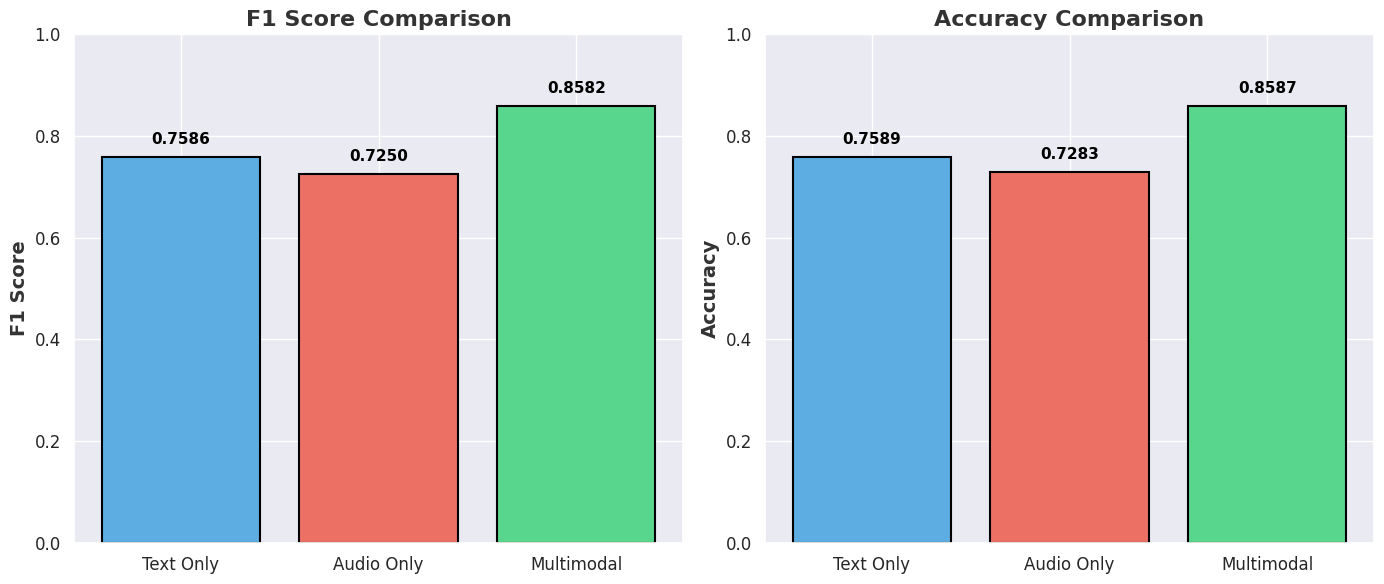

In [67]:
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(20, 24))

ax1 = plt.subplot(4, 3, 1)
models = ['Text Only', 'Audio Only', 'Multimodal']
f1_scores = [text_f1, audio_f1, multi_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, f1_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

ax2 = plt.subplot(4, 3, 2)
acc_scores = [text_acc, audio_acc, multi_acc]
bars = ax2.bar(models, acc_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, acc_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')


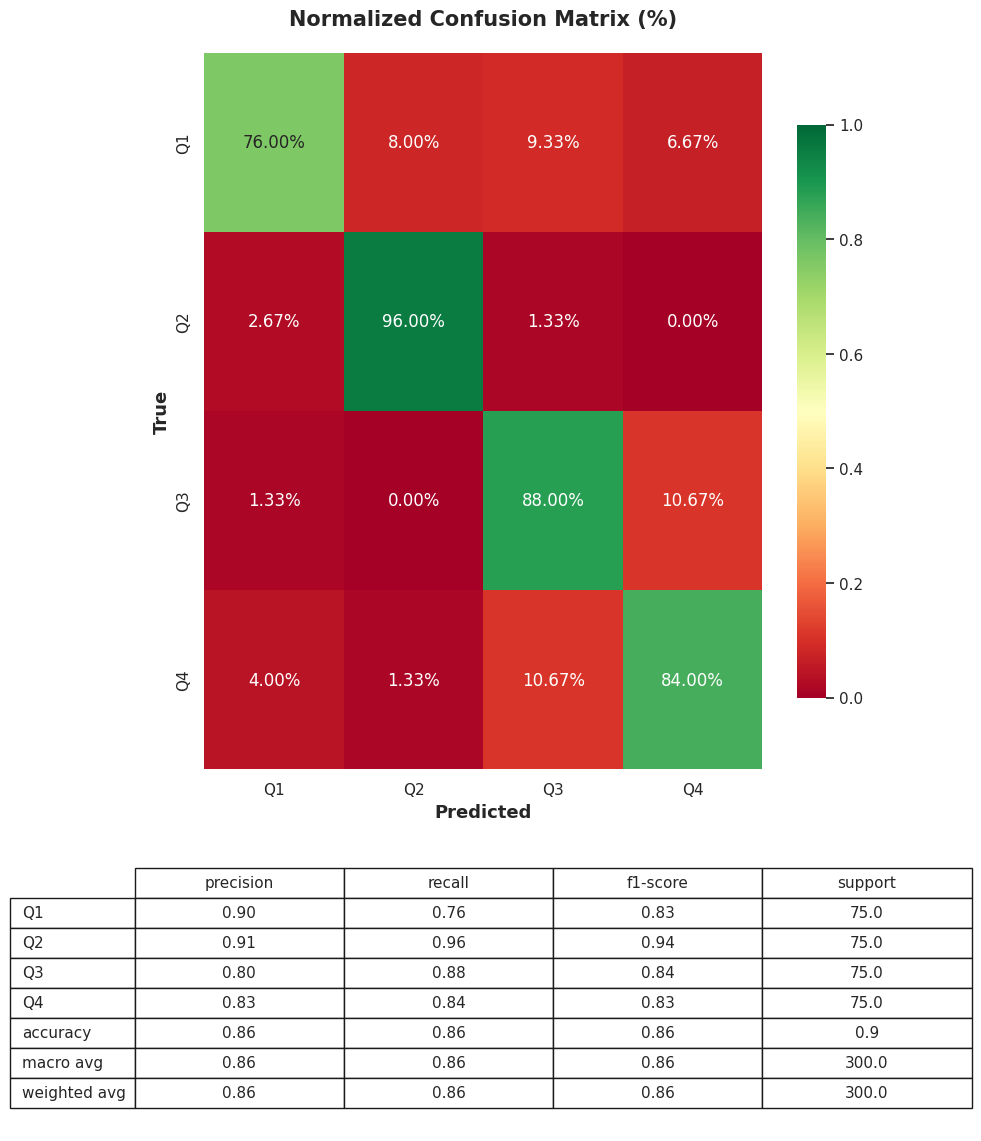

In [72]:
cm = confusion_matrix(multi_labels, multi_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

report_dict = classification_report(multi_labels, multi_preds,
                                    target_names=['Q1', 'Q2', 'Q3', 'Q4'],
                                    output_dict=True)

metrics_df = pd.DataFrame(report_dict).transpose()
metrics_df = metrics_df.round(2)

fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1])
ax_heatmap = fig.add_subplot(gs[0])
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='RdYlGn', cbar=True,
            xticklabels=['Q1', 'Q2', 'Q3', 'Q4'],
            yticklabels=['Q1', 'Q2', 'Q3', 'Q4'],
            annot_kws={'size': 14}, ax=ax_heatmap)

ax_heatmap.set_xlabel('Predicted', fontsize=14, fontweight='bold')
ax_heatmap.set_ylabel('True', fontsize=14, fontweight='bold')
ax_heatmap.set_title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold')

ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')
table = ax_table.table(cellText=metrics_df.values,
                       rowLabels=metrics_df.index,
                       colLabels=metrics_df.columns,
                       cellLoc='center', rowLoc='center',
                       loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()

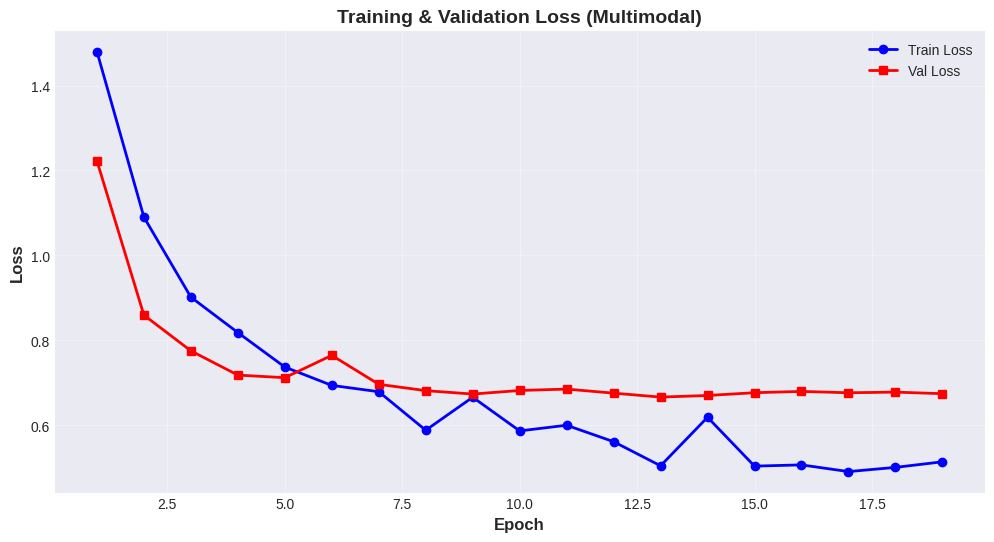

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

epochs = range(1, len(multimodal_history['train_loss']) + 1)

ax.plot(epochs, multimodal_history['train_loss'], 'b-', linewidth=2, label='Train Loss', marker='o')
ax.plot(epochs, multimodal_history['val_loss'], 'r-', linewidth=2, label='Val Loss', marker='s')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training & Validation Loss (Multimodal)', fontsize=14, fontweight='bold')

ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

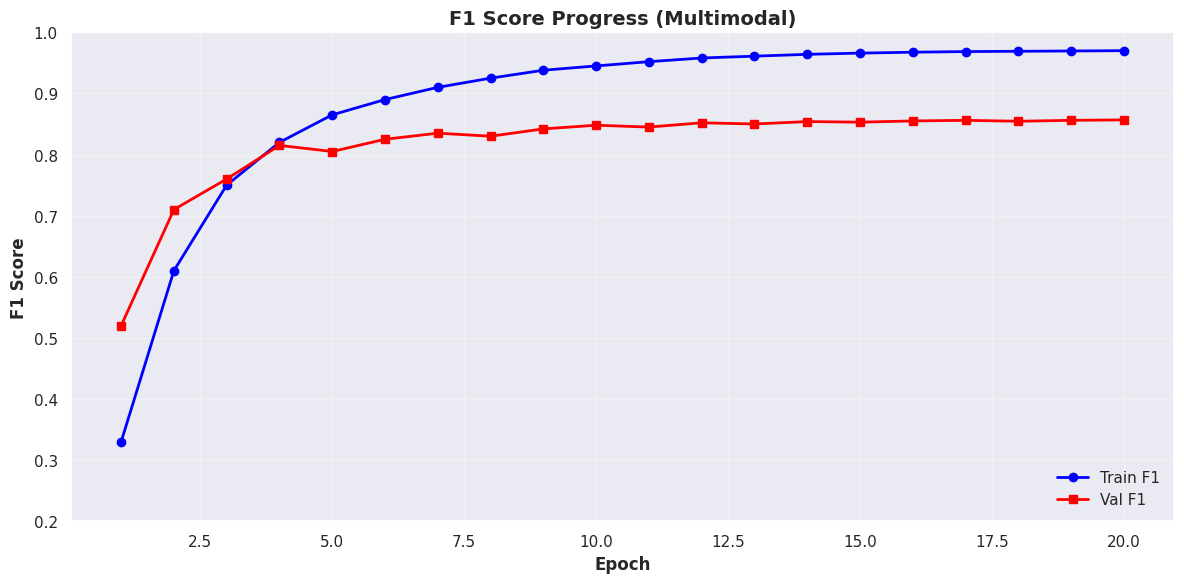

In [79]:
fig, ax7 = plt.subplots(figsize=(12, 6))

epochs = range(1, len(multimodal_history['train_f1']) + 1)

ax7.plot(epochs, multimodal_history['train_f1'], 'b-', linewidth=2, label='Train F1', marker='o')
ax7.plot(epochs, multimodal_history['val_f1'], 'r-', linewidth=2, label='Val F1', marker='s')

ax7.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax7.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax7.set_title('F1 Score Progress (Multimodal)', fontsize=14, fontweight='bold')

ax7.legend()
ax7.grid(True, alpha=0.3)

plt.show()

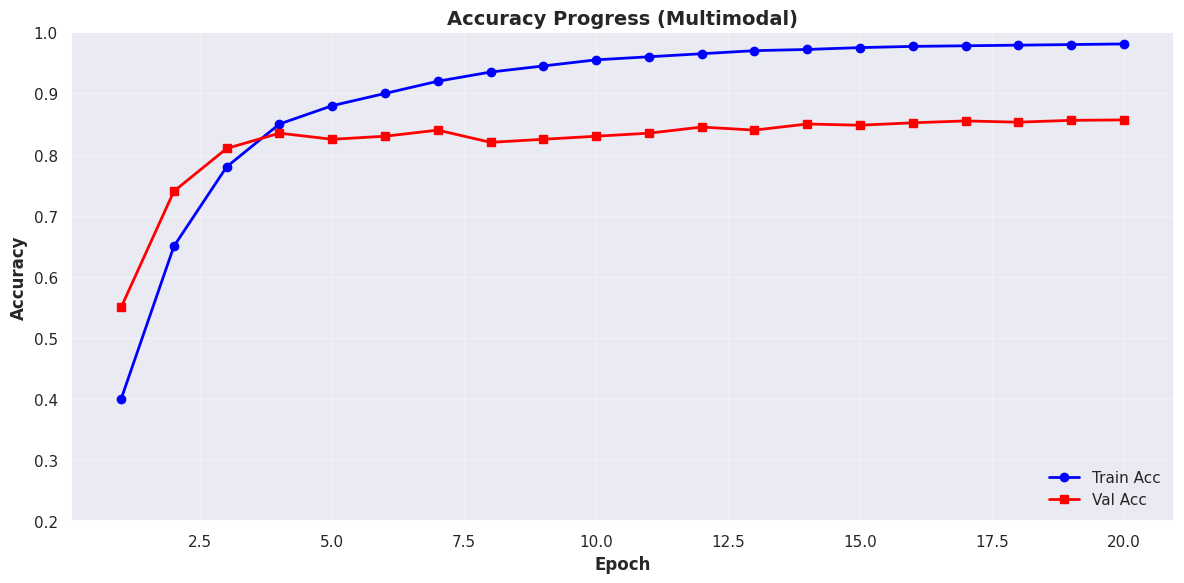

In [81]:
fig, ax8 = plt.subplots(figsize=(12, 6))

epochs = range(1, len(multimodal_history['train_acc']) + 1)

ax8.plot(epochs, multimodal_history['train_acc'], 'b-', linewidth=2, label='Train F1', marker='o')
ax8.plot(epochs, multimodal_history['val_acc'], 'r-', linewidth=2, label='Val F1', marker='s')

ax8.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax8.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax8.set_title('Accuracy Progress (Multimodal)', fontsize=14, fontweight='bold')

ax8.legend()
ax8.grid(True, alpha=0.3)

plt.show()

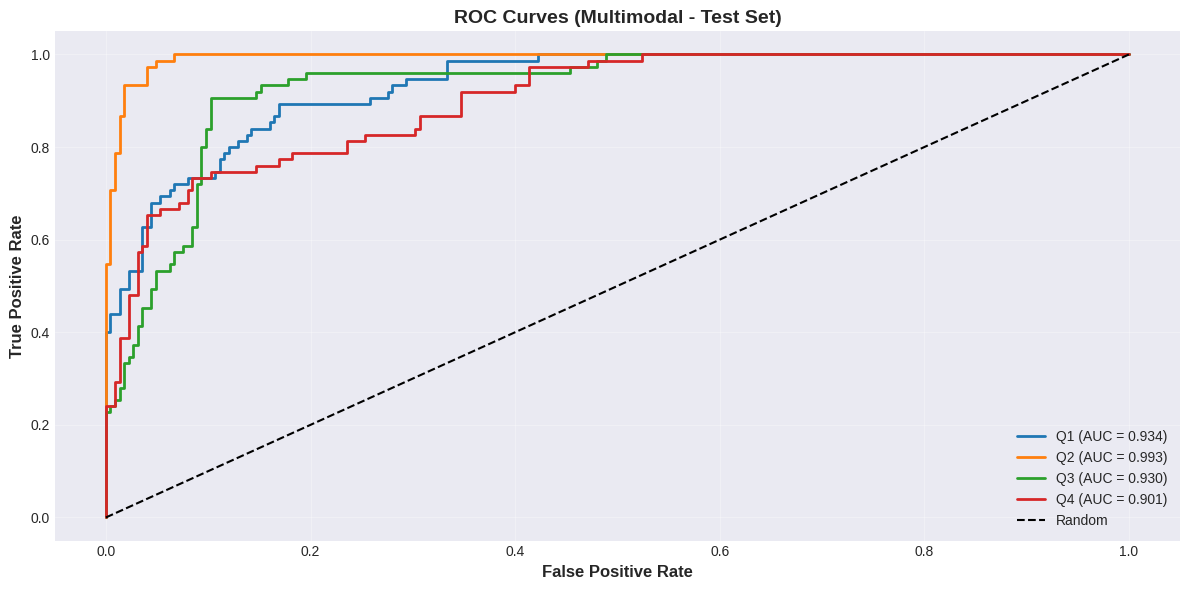

In [59]:
fig, ax11 = plt.subplots(figsize=(12, 6))
multi_labels_bin = label_binarize(multi_labels, classes=[0, 1, 2, 3])
multi_probs_array = np.array(multi_probs)

for i in range(4):
    fpr, tpr, _ = roc_curve(multi_labels_bin[:, i], multi_probs_array[:, i])
    roc_auc = auc(fpr, tpr)
    ax11.plot(fpr, tpr, linewidth=2, label=f'Q{i+1} (AUC = {roc_auc:.3f})')

ax11.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax11.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax11.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax11.set_title('ROC Curves (Multimodal - Test Set)', fontsize=14, fontweight='bold')
ax11.legend(loc='lower right')
ax11.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()